In [40]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patheffects as PathEffects
import pandas as pd
sys.path.append('../')
from hamiltonian import *
from parameters import *

old_settings = np.seterr(divide='ignore', invalid='ignore') # Necessary to suppress warnings for low T

Orbital relaxation time as a function of strain and temperature

In [24]:
# Find magnitude of B-field needed for qubit frequency at given B-field angle
i_defect = 0 # model SiV
H, _, p = create_hamiltonian()

alpha = np.linspace(0, 6*Ls[i_defect], 200)
B = np.linspace(0, 50, 300)
theta = np.linspace(0, 90, 200)*np.pi/180
alphaH, BH, thetaH, _ = tensor_repeat(alpha, B, theta, np.zeros((4,4)))

BHx = BH*np.sin(thetaH)
BHz = BH*np.cos(thetaH)

f_target = 1 # [GHz] Target qubit frequency
BH = target_frequency_parameters(f_target, BH, 1, BHx, 0, BHz, qs[i_defect], Ls[i_defect], alphaH, 0)

# Re-calculate eigenvalues
BH, _ = tensor_repeat(BH, np.zeros((4,4)))
alphaH = alphaH[:,0,:]
thetaH = thetaH[:,0,:]
BHx = BH*np.sin(thetaH)
BHz = BH*np.cos(thetaH)

Hgiv = H(BHx, 0, BHz, qs[i_defect], Ls[i_defect], alphaH, 0)
E, U = np.linalg.eigh(Hgiv)
E_Q, E_orb, lambda_eff = diagonalised_hamiltonian_parameters( E )


In [25]:
# Reshape variables
T = np.array([1, 4])

alphaH, thetaH, TH, _ = tensor_repeat( alpha, theta, T, np.zeros((4,4)) )
BH, _, _ = tensor_repeat( BH[...,0,0], T, np.zeros((4,4)))
BHx = BH*np.sin(thetaH)
BHz = BH*np.cos(thetaH)
Hgiv = H(BHx, 0, BHz, qs[i_defect], Ls[i_defect], alphaH, 0)
E, U = np.linalg.eigh(Hgiv)

In [26]:
# Find cyclicity
Hgiv = H(BHx, 0, BHz, qs[i_defect], L_excs[i_defect], alphaH*(d_exc[i_defect]+f_exc[i_defect])/(d[i_defect]+f[i_defect]), 0)
E_exc, U_exc = np.linalg.eigh(Hgiv)

transition = np.einsum('...ji,mjk,...kl->...mil',U_exc.conj(), p, U)
transition = np.einsum('...ijk,i->...jk', np.abs(transition)**2, np.array([1,1,2]))
cyclicity = 1/( 1 - (transition[...,0,0] + transition[...,0,2]) / (transition[...,0,:].sum(axis=-1)) )

In [27]:
# Calculate SiV spin T2

gamma_T1 = [None]*3
gamma_T2 = [None]*3
gammaOrb = [None]*3

for i in range(3):
    gamma_T1[i], gamma_T2[i], gammaOrb[i] = calculate_gamma(E, U, chi_err[i,i_defect], TH)

gamma_T1 = np.array(gamma_T1)
gamma_T2 = np.array(gamma_T2)
gammaOrb = np.array(gammaOrb)

T_target = 4
i_T = np.argmin( np.abs(T-T_target))

T2_corr_img = T_eff_approx( 0.5*gamma_T1[0,...,i_T], 0.5*gammaOrb[0,...,i_T], lambda_eff*1e9 + 1e2)
lambda_eff_img = np.array(lambda_eff)

In [28]:
# Find magnitude of B-field to hit target qubit frequency

T = np.linspace(0.1, 8, 300)
alpha_img = np.array(alpha)
alpha = 100
theta = np.array([0, 90])*np.pi/180
B = np.linspace(1, 50, 100)
Ls = np.array(Ls)
qs = np.array(qs)
chiH = np.array(chi)[np.array([0,2])]

LH, thetaH, BH, _ = tensor_repeat( Ls[np.array([0,2])], theta, B, np.zeros((4,4)))
qH, _, _, _ = tensor_repeat( qs[np.array([0,2])], theta, B, np.zeros((4,4)))

BHx = np.sin(thetaH)*BH
BHz = np.cos(thetaH)*BH

BH = target_frequency_parameters(f_target, BH, 2, BHx, 0, BHz, qH, LH, alpha, 0)

# Reshape everything
BH, TH, _ = tensor_repeat( BH, T, np.zeros((4,4)))
qH, thetaH, _, _ = tensor_repeat( qs[np.array([0,2])], theta, T, np.zeros((4,4)))
LH, _, _, _ = tensor_repeat( Ls[np.array([0,2])], theta, T, np.zeros((4,4)))
chiH, _, _ = tensor_repeat( chiH, theta, T)

BHx = np.sin(thetaH)*BH
BHz = np.cos(thetaH)*BH

In [29]:
# Find coherence time
H, _, _ = create_hamiltonian()
Hgiv = H(BHx, 0, BHz, qH, LH, alpha, 0)
E, U = np.linalg.eigh(Hgiv)

E_Q, E_orb, lambda_eff = diagonalised_hamiltonian_parameters( E )

gamma_T1, gamma_T2, gammaOrb = calculate_gamma(E, U, chiH, TH)

T2_corr = T_eff_approx( 0.5*gamma_T1 + 1e-2, 0.5*gammaOrb, lambda_eff*1e9)

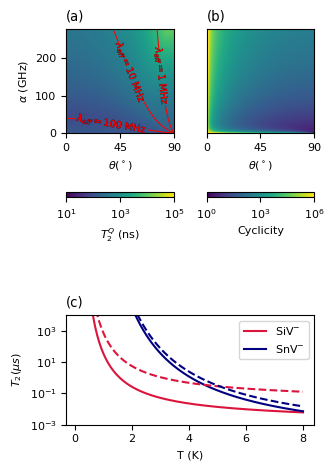

In [56]:
# Plot result
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(3.38583, 1.4*3.38583))
gs = plt.GridSpec(ncols=2, nrows=4, height_ratios=[0.95,.05,.01,1], hspace=.5)

# Plot corrected SiV
plt.subplot(gs[0,0])

im = plt.imshow(1e9*T2_corr_img, aspect='auto', extent=[0, 90, 0, alpha_img[-1]], origin='lower', norm=LogNorm(vmin=10, vmax=1e5))

fmt = lambda x: r'$\lambda_{eff}=$' + f'{1000*x:.0f} MHz'
CS = plt.contour( lambda_eff_img, [1e-3, 1e-2, 1e-1], extent=[0, 90, 0, alpha_img[-1]], colors='red', linewidths=0.75 )
txt = plt.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=7, manual = [(80,150),(45,150),(40,50)])
for x in txt:
    x.set_color('red')
    x.set_path_effects([PathEffects.withStroke(linewidth=.25, foreground='k')])

plt.xlabel(r'$\theta (^\circ)$')
plt.xticks([0,45,90])
plt.ylabel(r'$\alpha$ (GHz)')
plt.title('(a)', loc='left')

cax = plt.subplot(gs[1,0])
plt.colorbar(im, cax=cax, orientation='horizontal', label=r'$T_2^{Q}$ (ns)')
plt.xticks([1e1, 1e3, 1e5])

# Plot cyclicity
plt.subplot(gs[0,1])

im = plt.imshow(cyclicity[:,:,0], extent=[0, 90, 0, alpha_img[-1]], origin='lower', aspect='auto', norm=LogNorm(vmin=1, vmax=1e6))

plt.xlabel(r'$\theta (^\circ)$')
plt.xticks([0,45,90])
plt.yticks([])
plt.title('(b)', loc='left')

cax = plt.subplot(gs[1,1])
plt.colorbar(im, cax=cax, orientation='horizontal', label=r'Cyclicity')
plt.xticks([1e0, 1e3, 1e6])

colors = ['crimson', 'navy']
labels = [r'SiV$^{-}$', r'SnV$^{-}$']

# Plot coherence improvement
plt.subplot(gs[-1,:])
[ plt.semilogy( T, 1e6/gamma_T2[i, 0, :], color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
[ plt.semilogy( T, 1e6*T2_corr[i, 1, :], '--', color=colors[i] ) for i in range(len(labels)) ]

plt.legend()
plt.ylim( 1e-3, 1e4 )

plt.ylabel(r'$T_2 (\mu s)$')
plt.xlabel(r'T (K)')
plt.title('(c)', loc='left')

gs.tight_layout(fig)
plt.savefig("Fig4_Prediction.pdf")

plt.show()